In [1]:
# === Requirements / Imports ===
import os
import wrds
from dotenv import load_dotenv

# Data handling
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

In [2]:
load_dotenv()
wrds_user = os.getenv("WRDS_USER")

start_time = '1990-01-01'
end_time = '2024-12-31'

# Connect to WRDS
db = wrds.Connection(wrds_username=wrds_user)

Loading library list...
Done


In [3]:
# ===========================
# Compustat (Annual) data
# ===========================
# 1) Pull Compustat ANNUAL fundamentals
funda = db.raw_sql(f"""
    select gvkey, datadate, fyear, fyr,
           at,        -- total assets
           ceq,       -- common equity
           seq,       -- stockholders' equity
           txditc,    -- deferred taxes (balance sheet)
           pstk, pstkl, pstkrv,  -- preferred stock (various measures)
           sale, revt, cogs,     -- sales / revenue / COGS
           ib, ni, oiadp, oibdp, xint, xsga, dp,  -- income measures, depreciation, interest, SG&A
           dltt, dlc,              -- long-term and short-term debt
           capx,       -- capital expenditures
           che,        -- cash & equivalents
           act, lct,   -- current assets / current liabilities
           invt, ppent,-- inventory / net PPE
           xrd, xad,   -- R&D / advertising
           dvc         -- cash dividends (common)
    from comp.funda
    where indfmt = 'INDL' and datafmt = 'STD' and popsrc = 'D' and consol = 'C'
      and datadate between '2010-01-01' and '2020-12-31'
""")
db.close()

In [8]:
# 2) Prep
funda['datadate'] = pd.to_datetime(funda['datadate'], errors='coerce')
funda = funda.sort_values(['gvkey','datadate']).reset_index(drop=True)
num_cols = [c for c in funda.columns if c not in ['gvkey','datadate','fyear','fyr']]
for c in num_cols:
    funda[c] = pd.to_numeric(funda[c], errors='coerce')

# 3) Helper(s)
eps = 1e-12
def nz(x):  # safe denominator
    return x.where(x.abs() > eps, np.nan)

# --- Book Equity pieces (FF-style) ---
# BE = seq + txditc - pstk; if seq missing, fall back to (ceq + pstk) or at - lt (not pulled here)
pstk_fill = funda[['pstk','pstkl','pstkrv']].bfill(axis=1).iloc[:,0]
be = funda['seq']
be = be.fillna(funda['ceq'] + pstk_fill)  # fallback if seq missing
be = be + funda['txditc'].fillna(0) - pstk_fill.fillna(0)
funda['be'] = be.replace([np.inf,-np.inf], np.nan)

# 4) Lags for growth/ratios that need prior-year values
grp = funda.groupby('gvkey')
for col in ['at','sale','revt','be','act','lct','dltt','dlc','ppent','invt','che','capx','oiadp','oibdp','ib']:
    funda[f'L1_{col}'] = grp[col].shift(1)

# 5) Build **many** factors (annual, per-assets unless noted)

# Size
funda['size_log_at']          = np.log(nz(funda['at']))

# Book variables (use later with CRSP ME to form BM)
funda['be_pos']               = funda['be'].where(funda['be']>0)  # keep positive BE
# (BM itself should be computed after you merge with market equity from CRSP)

# Leverage
funda['lev_total_at']         = (funda['dltt'].fillna(0) + funda['dlc'].fillna(0)) / nz(funda['at'])
funda['lev_long_at']          = funda['dltt'] / nz(funda['at'])
funda['lev_short_at']         = funda['dlc'] / nz(funda['at'])

# Profitability
funda['roa']                  = funda['ib'] / nz(funda['at'])
funda['roe']                  = funda['ib'] / nz(funda['ceq'])
# Operating profitability (FF 2015 flavor; two denominators for flexibility)
funda['op_at']                = (funda['revt'] - funda['cogs'] - funda['xsga'].fillna(0) - funda['xint'].fillna(0)) / nz(funda['at'])
funda['op_be']                = (funda['revt'] - funda['cogs'] - funda['xsga'].fillna(0) - funda['xint'].fillna(0)) / nz(funda['be_pos'])
# Gross profitability (Novy-Marx)
funda['gross_prof_at']        = (funda['revt'] - funda['cogs']) / nz(funda['at'])
# Margins
funda['gross_margin']         = (funda['revt'] - funda['cogs']) / nz(funda['revt'])
funda['ebitda_margin']        = funda['oibdp'] / nz(funda['revt'])
funda['oper_margin']          = funda['oiadp'] / nz(funda['revt'])

# Growth / Investment
funda['asset_growth_yoy']     = (funda['at'] / nz(funda['L1_at'])) - 1
funda['sales_growth_yoy']     = (funda['sale'] / nz(funda['L1_sale'])) - 1
funda['capex_to_at']          = funda['capx'] / nz(funda['at'])
funda['capex_to_L1at']        = funda['capx'] / nz(funda['L1_at'])  # investment rate
funda['ppe_growth_yoy']       = (funda['ppent'] / nz(funda['L1_ppent'])) - 1
funda['inv_growth_yoy']       = (funda['invt'] / nz(funda['L1_invt'])) - 1

# Intangibles / Spending
funda['rd_to_at']             = funda['xrd'] / nz(funda['at'])
funda['adv_to_at']            = funda['xad'] / nz(funda['at'])

# Liquidity / Working capital
funda['cash_to_at']           = funda['che'] / nz(funda['at'])
funda['wc_to_at']             = ((funda['act'] - funda['lct']) / nz(funda['at']))
funda['dWC_to_L1at']          = (((funda['act'] - funda['lct']) - (funda['L1_act'] - funda['L1_lct'])) / nz(funda['L1_at']))

# Accrual proxies (simple)
# Sloan-style working-capital accruals proxy (no OANCF): delta(CA-CL) - delta(Cash) + delta(DLC)
funda['wc_accruals_to_at']    = (
    ((funda['act'] - funda['lct']) - (funda['L1_act'] - funda['L1_lct']))
    - (funda['che'] - funda['L1_che']).fillna(0)
    + (funda['dlc'] - funda['L1_dlc']).fillna(0)
) / nz(funda['at'])

# Capital structure / tangibility
funda['tangibility']          = funda['ppent'] / nz(funda['at'])
funda['inventory_to_at']      = funda['invt'] / nz(funda['at'])

# Payout
funda['payout_div_earn']      = funda['dvc'] / nz(funda['ib'])   # cap at reasonable bounds later

# 6) Keep tidy feature set
annual_features = funda[[
    'gvkey','datadate','fyear','fyr',
    # core building blocks
    'at','be','ceq','dltt','dlc','sale','revt','cogs','oibdp','oiadp','xint','xsga','capx','che','act','lct','ppent','invt','xrd','xad','dvc','ib',
    # features
    'size_log_at','be_pos',
    'lev_total_at','lev_long_at','lev_short_at',
    'roa','roe','op_at','op_be','gross_prof_at','gross_margin','ebitda_margin','oper_margin',
    'asset_growth_yoy','sales_growth_yoy','capex_to_at','capex_to_L1at','ppe_growth_yoy','inv_growth_yoy',
    'rd_to_at','adv_to_at','cash_to_at','wc_to_at','dWC_to_L1at','wc_accruals_to_at',
    'tangibility','inventory_to_at','payout_div_earn'
]].copy()

# 8) De-duplicate (just in case)
annual_features['year'] = annual_features['fyear'].fillna(annual_features['datadate'].dt.year)
annual_features = annual_features.drop_duplicates(subset=['gvkey','year'], keep='last').reset_index(drop=True)


In [9]:
annual_features.head()

,gvkey,datadate,fyear,fyr,at,be,ceq,dltt,dlc,sale,...,rd_to_at,adv_to_at,cash_to_at,wc_to_at,dWC_to_L1at,wc_accruals_to_at,tangibility,inventory_to_at,payout_div_earn,year
0,001004,2010-05-31,2009,5,1501.042,804.241,746.906,336.191,100.833,1352.151,...,<NA>,<NA>,0.052877,0.358337,<NA>,<NA>,0.222799,0.331039,0.0,2009
1,001004,2011-05-31,2010,5,1703.727,934.167,835.845,329.802,114.075,1775.782,...,<NA>,<NA>,0.03371,0.292286,-0.026584,-0.002773,0.245206,0.297744,0.040785,2010
2,001004,2012-05-31,2011,5,2195.653,980.557,864.649,669.489,122.865,2074.498,...,<NA>,<NA>,0.030843,0.268734,0.054041,0.041252,0.20769,0.273154,0.178388,2011
3,001004,2013-05-31,2012,5,2136.9,1056.8,918.6,622.2,86.4,2167.1,...,<NA>,<NA>,0.035238,0.301699,0.024892,0.004965,0.199541,0.272778,0.216364,2012
4,001004,2014-05-31,2013,5,2199.5,1161.7,999.5,564.3,69.7,2035.0,...,<NA>,<NA>,0.040555,0.324983,0.032805,0.017959,0.187906,0.287747,0.161866,2013


In [10]:
df = annual_features.copy()
# df['year'] = df['fyear'].fillna(df['datadate'].dt.year)
# Option: drop clear identifiers / targets / duplicates of same info
id_cols = ['gvkey', 'datadate', 'fyear', 'fyr', 'year']
# Candidate feature columns = all numeric except identifiers
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in num_cols if c not in ['year','fyear','fyr']]

In [11]:
df.shape

(126769, 55)

In [12]:
# 2) Handle missingness: drop high-missing features, then impute -------------
# Drop features with too many NaNs across the whole panel (e.g., >40%)
na_ratio = df[feature_cols].isna().mean()
kept_features = [c for c in feature_cols if na_ratio[c] <= 0.40]
X = df[kept_features].copy()

In [13]:
X.shape

(126769, 41)

In [14]:
# 3) Robust cross-sectional preprocessing by year ---------------------------
# Within each year: winsorize to mitigate outliers, then z-score.

def winsorize_series(s, p=0.01):
    lo, hi = s.quantile(p), s.quantile(1-p)
    return s.clip(lo, hi)

def cs_winsorize(df_year):
    return df_year.apply(lambda s: winsorize_series(s, p=0.01))

def cs_zscore(df_year):
    std = df_year.std(ddof=0).replace(0, np.nan)
    return (df_year - df_year.mean()) / std

def cs_impute_median(df_year):
    med = df_year.median()
    return df_year.fillna(med).fillna(0)

# Apply by year (only on X)
x_proc_list = list()
for y, g in df.assign(_row_id=np.arange(len(df))).groupby('year'):
    block = g[kept_features].replace([np.inf, -np.inf], np.nan)
    block = cs_impute_median(block)
    block = cs_winsorize(block)
    block = cs_zscore(block)

    block = block.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype('float64')

    block['_row_id'] = g['_row_id'].values
    x_proc_list.append(block)

X_proc = pd.concat(x_proc_list, axis=0).sort_values('_row_id').drop(columns='_row_id').reset_index(drop=True)

# After concatenation, remove problematic columns (some columns may still be all constant/all NaN across years)
all_nan_cols = X_proc.columns[X_proc.isna().all(axis=0)]
if len(all_nan_cols):
    print("Drop all-NaN cols:", list(all_nan_cols))
    X_proc = X_proc.drop(columns=all_nan_cols)

zero_std_cols = X_proc.columns[X_proc.std(ddof=0) == 0]
if len(zero_std_cols):
    print("Drop zero-std cols:", list(zero_std_cols))
    X_proc = X_proc.drop(columns=zero_std_cols)

# Final check
assert np.isfinite(X_proc.values).all(), "Still have NaN/Inf in X_proc!"
print("X_proc shape:", X_proc.shape, "| dtype:", X_proc.dtypes.unique())

X_proc shape: (126769, 41) | dtype: [dtype('float64')]


In [15]:
pca = PCA()                         # keep all
pca.fit(X_proc.values)             # ensure ndarray

expl_var = pca.explained_variance_ratio_
cum_var  = np.cumsum(expl_var)
print("Explained variance (first 10):", np.round(expl_var[:10], 4))
print("Cumulative   (first 10):", np.round(cum_var[:10], 4))

Explained variance (first 10): [0.3857 0.1126 0.0699 0.0595 0.0417 0.0368 0.0331 0.0267 0.0259 0.0229]
Cumulative   (first 10): [0.3857 0.4984 0.5682 0.6277 0.6695 0.7063 0.7394 0.7661 0.792  0.8149]


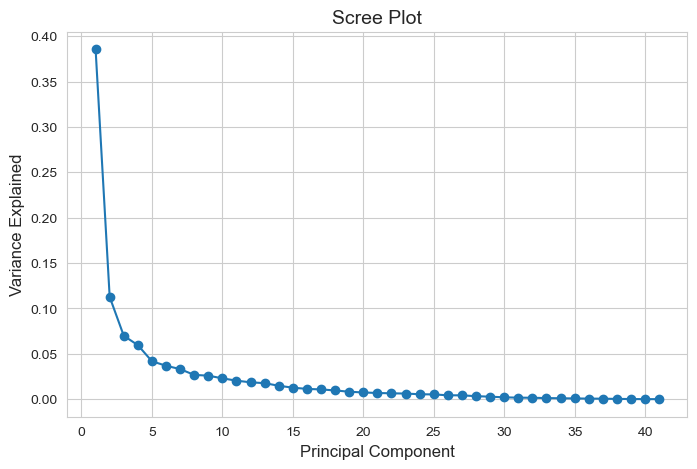

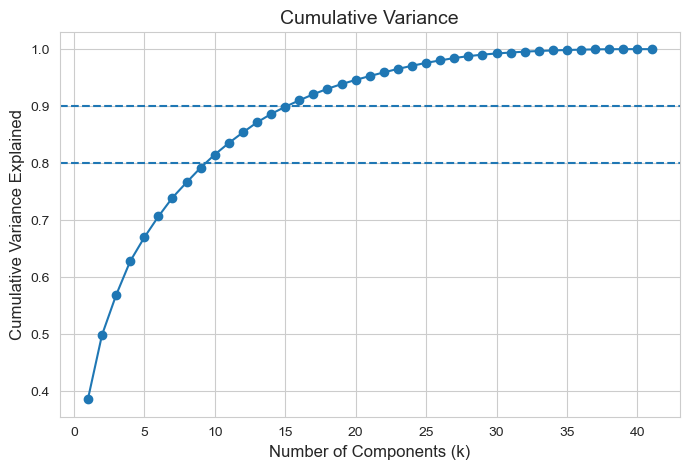

In [16]:
# 5) Scree plot & cumulative variance ---------------------------------------
plt.figure()
plt.plot(range(1, len(expl_var)+1), expl_var, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Scree Plot")
plt.show()

plt.figure()
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.xlabel("Number of Components (k)")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance")
plt.axhline(0.80, linestyle='--')  # e.g., 80% threshold
plt.axhline(0.90, linestyle='--')  # e.g., 90% threshold
plt.show()

In [17]:
# 6) Interpret top loadings for PC1/PC2/PC3 ---------------------------------
loadings = pd.DataFrame(pca.components_.T, index=X_proc.columns,
                        columns=[f'PC{i}' for i in range(1, len(kept_features)+1)])

def top_loadings(load_df, pc='PC1', top=8):
    s = load_df[pc]
    return pd.DataFrame({
        'feature': pd.concat([s.sort_values(ascending=False).head(top),
                              s.sort_values(ascending=True).head(top)]).index,
        'loading': pd.concat([s.sort_values(ascending=False).head(top),
                              s.sort_values(ascending=True).head(top)]).values
    }).reset_index(drop=True)

print("\nTop loadings — PC1")
print(top_loadings(loadings, 'PC1', top=6))

print("\nTop loadings — PC2")
print(top_loadings(loadings, 'PC2', top=6))

print("\nTop loadings — PC3")
print(top_loadings(loadings, 'PC3', top=6))


Top loadings — PC1
             feature   loading
0              oibdp  0.239411
1               revt  0.235470
2               sale  0.235470
3             be_pos  0.233547
4                 be  0.233542
5              oiadp  0.232590
6         cash_to_at -0.037032
7       lev_short_at -0.018536
8       lev_total_at -0.011623
9   asset_growth_yoy -0.010142
10               roe  0.008608
11     capex_to_L1at  0.008770

Top loadings — PC2
          feature   loading
0           op_at  0.408498
1             roa  0.399211
2        wc_to_at  0.386571
3     size_log_at  0.236579
4   ebitda_margin  0.224018
5     oper_margin  0.223449
6    lev_short_at -0.373567
7    lev_total_at -0.363431
8      cash_to_at -0.128668
9             roe -0.045891
10    lev_long_at -0.037945
11            dlc -0.029907

Top loadings — PC3
             feature   loading
0      ebitda_margin  0.434389
1        oper_margin  0.434108
2       gross_margin  0.432909
3              op_be  0.263573
4      gross_prof_

In [18]:
# 7) Project observations onto first k PCs (optional for downstream tasks) ---
k = 3
pca_k = PCA(n_components=k)
scores = pca_k.fit_transform(X_proc.values)
scores_df = pd.DataFrame(scores, columns=[f'PC{i}' for i in range(1, k+1)])
# Merge back firm/date for exploration
demo = pd.concat([df[['gvkey','datadate','year']].reset_index(drop=True), scores_df], axis=1)
demo.head()

,gvkey,datadate,year,PC1,PC2,PC3
0,001004,2010-05-31,2009,-0.243346,0.653067,0.388690
1,001004,2011-05-31,2010,0.004269,0.695424,0.374133
2,001004,2012-05-31,2011,0.120487,0.655950,0.545628
3,001004,2013-05-31,2012,0.099216,0.785009,0.573887
4,001004,2014-05-31,2013,0.082069,0.824340,0.548599
